In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from CAP.collocation import *
import glob

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import cartopy.feature as cfeature

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import contrails.meteorology.thermo as cmt
from contrails.units import pres2alt

plt.rc("font", family="serif")

/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/vmeijer/.local/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Load flight data

In [3]:
res_df = pd.read_pickle("flight_data_for_figure.pkl")
res_df["alt_km"] = res_df["alt"] / 1000

### Load GRUAN data

In [4]:
gf = pd.concat([pd.read_pickle("../data/" + site + ".pkl") for site in ["BOU", "BEL", "SGP"]])


gf["ISS"] = gf["rhi"] > 1.0
gf["SAC"] = cmt.get_SAC(gf["press"] * 100, gf["temp"], gf["rh"])


gf["season"] = (gf.time.dt.month %12 //3 ) + 1
gf["season_name"] = gf["season"].map({1:"DJF", 2:"MAM", 3:"JJA", 4:"SON"})

gf["alt_geom_km"] = gf["alt"]/ 1000
gf["alt_km"] = pres2alt(gf.press * 100) / 1000

gf_balanced1 = gf[gf.site == "SGP"]
gf_balanced2 = gf.groupby(["site", "season_name"]).sample(3773, random_state=2)

/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Load contrail data

In [5]:
df = pd.read_pickle("../data/contrail_dataset_v9.pkl")
df["goes_time"] = pd.to_datetime(df['goes_time'])
df["season"] = (df.goes_time.dt.month %12 //3 ) + 1
df["season_name"] = df["season"].map({1:"DJF", 2:"MAM", 3:"JJA", 4:"SON"})
df["alt_km"] = df["caliop_top_height"] / 1000
df["alt_km"] = pres2alt(df["top_pressure_hPa"] * 100 * 100) / 1000


df_bal = df.groupby([df.goes_time, df.L1_file, df.goes_product, df.contrail_id])[["top_pressure_hPa"]].min() * 100
df_bal["alt_km"] = pres2alt(df_bal.top_pressure_hPa.values * 100) / 1000
df_bal["alt_geom_km"] =  df.groupby([df.goes_time, df.L1_file, df.goes_product, df.contrail_id]).caliop_top_height.max() / 1000
df_bal['season_name'] = df.groupby([df.goes_time, df.L1_file, df.goes_product, df.contrail_id]).first()["season_name"]

In [13]:
df_bal.alt_km.describe()

count    3267.000000
mean       11.381412
std         0.958791
min         7.836865
25%        10.805082
50%        11.457560
75%        12.042846
max        14.590357
Name: alt_km, dtype: float64

In [14]:
11.38 / 0.3048

37.335958005249346

In [7]:
df_bal.alt_km.min()

7.836864770546344

## Generate figure

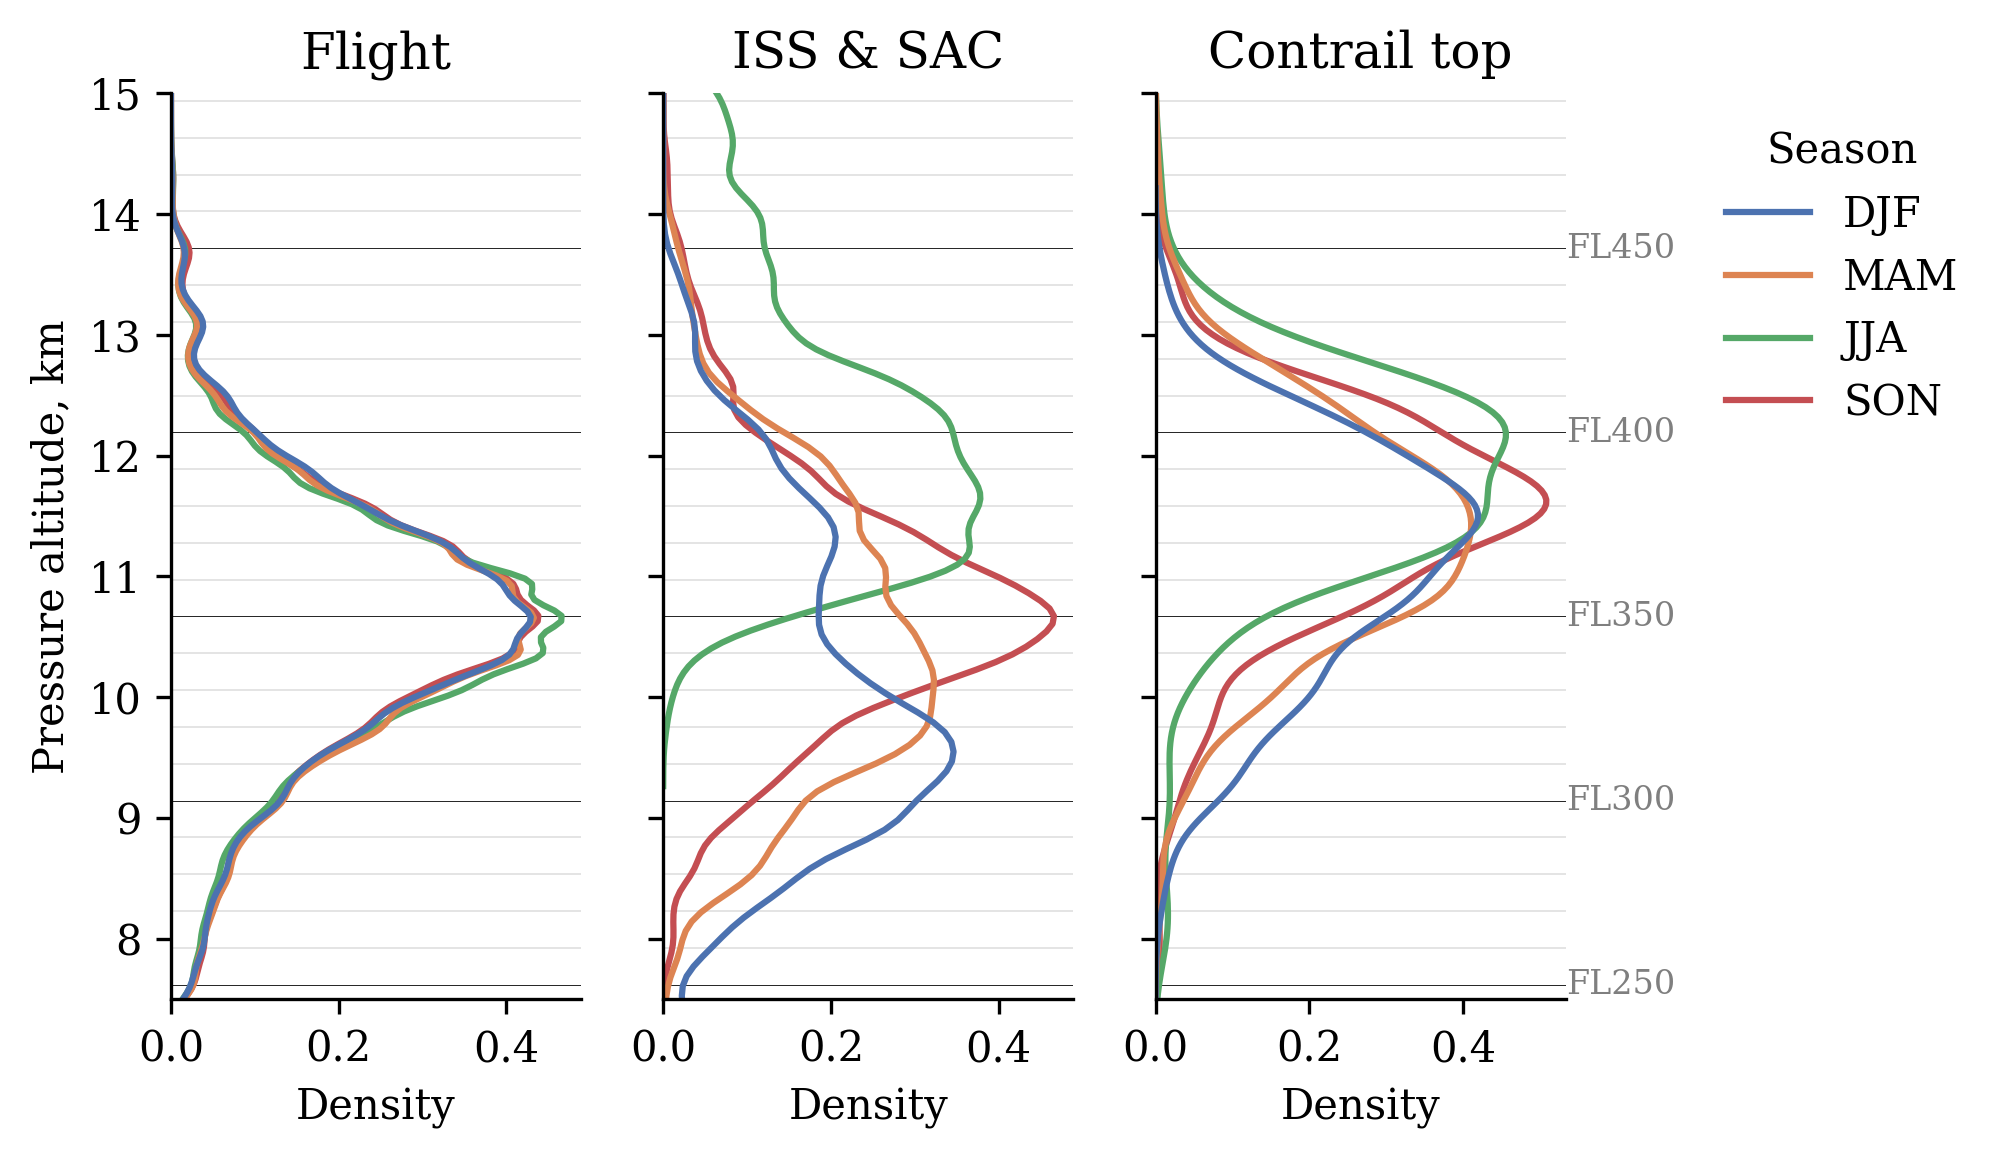

In [12]:
fig, axes = plt.subplots(dpi=300, ncols=3, sharey=True)


HUE_ORDER = ["DJF", "MAM", "JJA", "SON"]
PALETTE = sns.color_palette("deep", 4)
COMMON_NORM = False

sns.kdeplot(y="alt_km", hue="season_name",weights='dist',
           data=res_df, ax=axes[0], palette=PALETTE, hue_order=HUE_ORDER,
           common_norm=COMMON_NORM, legend=False)

sns.kdeplot(y="alt_km", hue="season_name",
           data=gf_balanced1[gf_balanced1.ISS&gf_balanced1.SAC].reset_index(), ax=axes[1], palette=PALETTE, hue_order=HUE_ORDER,
           common_norm=COMMON_NORM, legend=False)

sns.kdeplot(y="alt_km", 
            data=df_bal, hue="season_name", ax=axes[2], palette=PALETTE,
            hue_order=HUE_ORDER,
            common_norm=COMMON_NORM, legend=True) 


sns.move_legend(axes[2], "upper left",frameon=False,
                    title="Season", bbox_to_anchor=(1.3,1))


axes[0].set(ylabel="Pressure altitude, km", title="Flight")
axes[1].set(title="ISS & SAC")
axes[2].set(title="Contrail top")

for i in range(3):
    ax = axes[i]
    ax.set_ylim(7.5, 15)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    for FL in np.arange(180, 510, 10):


        if FL % 50 == 0:
            if i == 2:
                ax.annotate(f"FL{FL}", (ax.get_xlim()[-1], FL * 100 * 0.3048 / 1000),
                            ha="left", va="center",fontsize=8,
                           alpha=0.5)
            ax.axhline(FL * 100 * 0.3048 / 1000, c="k",
                  lw=0.2, zorder=-1)
        else:
            ax.axhline(FL * 100 * 0.3048 / 1000, c="k",
                  lw=0.05, zorder=-1)

            
#plt.savefig("height_by_season.png", dpi=300, bbox_inches="tight")